In [1]:
import pandas as pd
import re
import json

In [7]:
print(chatgpt_REs[1])

**Evaluation of LLM Response:**

1. **Correctness (8/10):**  
   The LLM response accurately describes "twisted gut" as a volvulus, which is consistent with the retrieved documents that discuss volvulus as a condition where the intestine twists around itself, potentially leading to obstruction and ischemia (Document 3, PMID: PMC11316191, 2024). The response also correctly identifies other potential causes of distress in infants, such as colic and dietary reactions, which are common considerations in pediatric care.

2. **Hallucination (9/10):**  
   The response does not contain any significant hallucinations. It provides plausible explanations for the symptoms described by the patient, such as volvulus and other common infant conditions. However, the mention of "intestinal dysbiosis" is not directly supported by the retrieved documents, though it is a recognized medical concept.

3. **Completeness (9/10):**  
   The response is comprehensive, addressing the patient's concern about a "

In [8]:
# Step 1: Load CSV
df = pd.read_csv("capstone_results.csv")

# Step 2: Extract columns
chatgpt_REs = df['chatgpt_RE'].to_list()
claude_REs = df['claude_RE'].to_list()
deepseek_REs = df['deepseek_RE'].to_list()
empathy = df['empathy evaluations'].to_list()

In [9]:
# Step 3: Extract Values from RE text
def extract_values(text):
    if pd.isna(text):
        return None
    match = re.search(r'(?:\d+\.\s*)?\*{1,2}Values:\*{1,2}\s*\[([\d\s,]+)\]', text, re.IGNORECASE)
    if not match:
        match = re.search(r'Values[^\[\]]*\[([^\]]+)\]', text, re.IGNORECASE)
    if match:
        try:
            values = [int(x.strip()) for x in re.split(r'[,\s]+', match.group(1)) if x.strip()]
            return values
        except:
            pass
    return None

chatgpt_scores = [extract_values(text) for text in chatgpt_REs]
claude_scores = [extract_values(text) for text in claude_REs]
deepseek_scores = [extract_values(text) for text in deepseek_REs]

In [10]:
# Step 4: Extract Empathy Ratings
def extract_ratings(json_string):
    if pd.isna(json_string):
        return None
    try:
        fixed_json = re.sub(r"(?<!\w)'|'(?!\w)", '"', json_string)
        data = json.loads(fixed_json)
        ratings = []
        for item in data['ratings']:
            if item.get('chatgpt response') == 'A1':
                ratings.append(item['rating'])
            elif item.get('claude response') == 'A2':
                ratings.append(item['rating'])
            elif item.get('deepseek response') == 'A3':
                ratings.append(item['rating'])
        return ratings
    except Exception as e:
        print(f"Empathy parsing error: {e}")
        return None

empathy_scores = [extract_ratings(text) for text in empathy]

In [11]:
# Step 5: Safe extraction helper
def safe_get(lst, idx, default=None):
    try:
        return lst[idx] if lst and len(lst) > idx else default
    except:
        return default

# Step 6: Build final structured DataFrame
final_data = []
for i in range(len(df)):
    row = {
        # ChatGPT
        'chatgpt_correctness': safe_get(chatgpt_scores[i], 0),
        'chatgpt_hallucination': safe_get(chatgpt_scores[i], 1),
        'chatgpt_completeness': safe_get(chatgpt_scores[i], 2),
        'chatgpt_faithfulness': safe_get(chatgpt_scores[i], 3),
        'chatgpt_groundedness': safe_get(chatgpt_scores[i], 4),
        'chatgpt_empathy': safe_get(empathy_scores[i], 0),

        # Claude
        'claude_correctness': safe_get(claude_scores[i], 0),
        'claude_hallucination': safe_get(claude_scores[i], 1),
        'claude_completeness': safe_get(claude_scores[i], 2),
        'claude_faithfulness': safe_get(claude_scores[i], 3),
        'claude_groundedness': safe_get(claude_scores[i], 4),
        'claude_empathy': safe_get(empathy_scores[i], 1),

        # DeepSeek
        'deepseek_correctness': safe_get(deepseek_scores[i], 0),
        'deepseek_hallucination': safe_get(deepseek_scores[i], 1),
        'deepseek_completeness': safe_get(deepseek_scores[i], 2),
        'deepseek_faithfulness': safe_get(deepseek_scores[i], 3),
        'deepseek_groundedness': safe_get(deepseek_scores[i], 4),
        'deepseek_empathy': safe_get(empathy_scores[i], 2),
    }
    final_data.append(row)

final_df = pd.DataFrame(final_data)

In [12]:
# Step 7: Preview the result
print(final_df.head())

   chatgpt_correctness  chatgpt_hallucination  chatgpt_completeness  \
0                  NaN                    NaN                   NaN   
1                  8.0                    9.0                   9.0   
2                  8.0                    9.0                   9.0   
3                  7.0                    8.0                   6.0   
4                  8.0                    7.0                   9.0   

   chatgpt_faithfulness  chatgpt_groundedness  chatgpt_empathy  \
0                   NaN                   NaN              NaN   
1                   8.0                   7.0              8.0   
2                   8.0                   7.0              9.0   
3                   7.0                   6.0              9.0   
4                   6.0                   5.0              7.0   

   claude_correctness  claude_hallucination  claude_completeness  \
0                 NaN                   NaN                  NaN   
1                 8.0                   

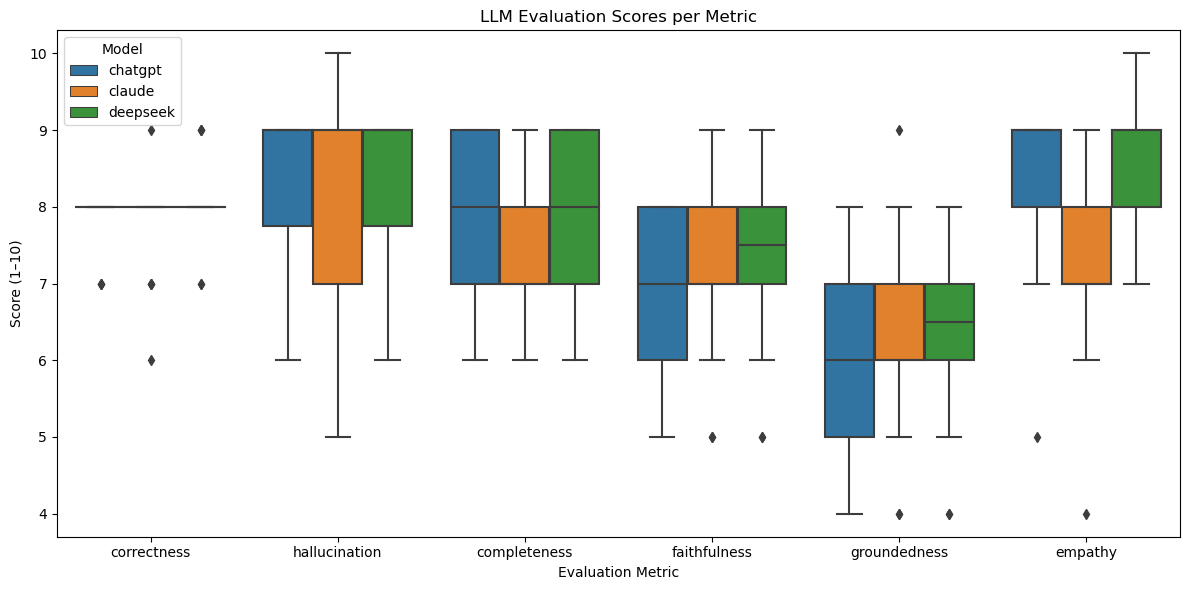

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Melt the DataFrame for seaborn
metrics = ['correctness', 'hallucination', 'completeness', 'faithfulness', 'groundedness', 'empathy']
melted_df = final_df.melt(
    value_vars=[f"{model}_{metric}" for model in ['chatgpt', 'claude', 'deepseek'] for metric in metrics],
    var_name='model_metric',
    value_name='score'
)

# Split model and metric into two columns
melted_df[['model', 'metric']] = melted_df['model_metric'].str.extract(r'(\w+)_(\w+)')

# Plot: Boxplot by Metric
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_df, x='metric', y='score', hue='model')
plt.title('LLM Evaluation Scores per Metric')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score (1–10)')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [16]:
import numpy as np

# Group columns by model
models = ['chatgpt', 'claude', 'deepseek']
metrics = ['correctness', 'hallucination', 'completeness', 'faithfulness', 'groundedness', 'empathy']

summary = {}

for model in models:
    for metric in metrics:
        col = f"{model}_{metric}"
        if col in final_df.columns:
            mean = np.nanmean(final_df[col])
            std = np.nanstd(final_df[col])
            summary[f"{model}_{metric}"] = f"{mean:.2f} ± {std:.2f}"

# Convert to readable table
summary_df = pd.DataFrame([summary])
summary_df = summary_df.T.reset_index()
summary_df.columns = ['Metric', 'Mean ± Std Dev']

# Reshape for better view
summary_df[['Model', 'Metric']] = summary_df['Metric'].str.extract(r'(\w+)_(\w+)')
summary_table = summary_df.pivot(index='Metric', columns='Model', values='Mean ± Std Dev')

print(summary_table)

Model              chatgpt       claude     deepseek
Metric                                              
completeness   7.89 ± 1.01  7.54 ± 0.82  8.07 ± 0.92
correctness    7.89 ± 0.31  7.86 ± 0.52  8.04 ± 0.42
empathy        8.32 ± 0.97  7.32 ± 1.00  8.82 ± 0.71
faithfulness   7.00 ± 0.96  7.25 ± 0.95  7.29 ± 0.96
groundedness   6.07 ± 1.03  6.32 ± 1.14  6.32 ± 1.00
hallucination  8.39 ± 0.94  8.21 ± 1.18  8.43 ± 0.94


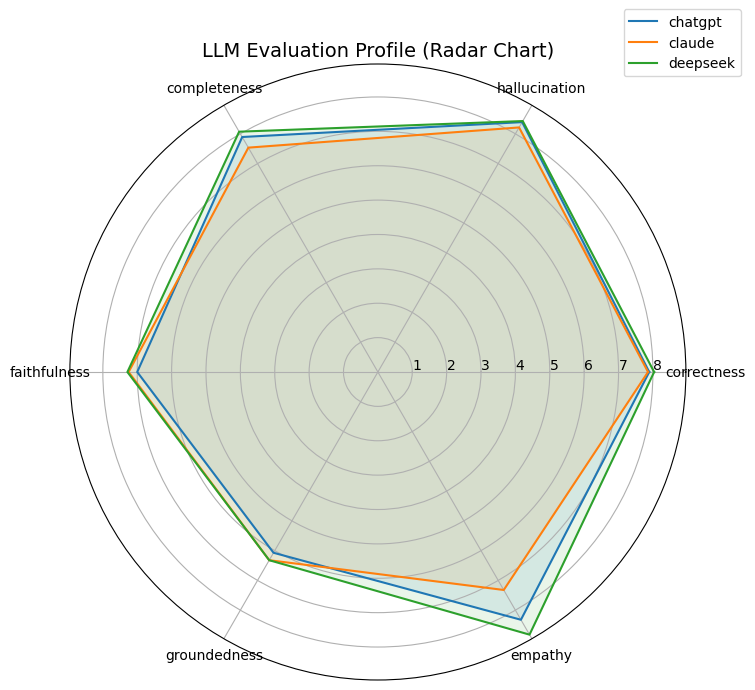

In [15]:
from math import pi
import matplotlib.pyplot as plt

# Mean scores only for radar
avg_scores = {
    model: [final_df[f"{model}_{metric}"].mean() for metric in metrics]
    for model in models
}

# Create radar chart
labels = metrics
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # repeat to close circle

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for model in models:
    values = avg_scores[model]
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("LLM Evaluation Profile (Radar Chart)", size=14)
ax.set_rlabel_position(0)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()



In [19]:
# Prepare results
ranking_summary = []

for metric in metrics:
    scores = {
        model: final_df[f"{model}_{metric}"].mean()
        for model in models
    }
    # Rank scores
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    winner = sorted_scores[0][0]
    ranking_summary.append({
        "Metric": metric.capitalize(),
        "1st": f"{sorted_scores[0][0]} ({sorted_scores[0][1]:.2f})",
        "2nd": f"{sorted_scores[1][0]} ({sorted_scores[1][1]:.2f})",
        "3rd": f"{sorted_scores[2][0]} ({sorted_scores[2][1]:.2f})",
        "Winner": winner
    })

# Create DataFrame
ranking_df = pd.DataFrame(ranking_summary)
print(ranking_df)


          Metric              1st              2nd             3rd    Winner
0    Correctness  deepseek (8.04)   chatgpt (7.89)   claude (7.86)  deepseek
1  Hallucination  deepseek (8.43)   chatgpt (8.39)   claude (8.21)  deepseek
2   Completeness  deepseek (8.07)   chatgpt (7.89)   claude (7.54)  deepseek
3   Faithfulness  deepseek (7.29)    claude (7.25)  chatgpt (7.00)  deepseek
4   Groundedness    claude (6.32)  deepseek (6.32)  chatgpt (6.07)    claude
5        Empathy  deepseek (8.82)   chatgpt (8.32)   claude (7.32)  deepseek


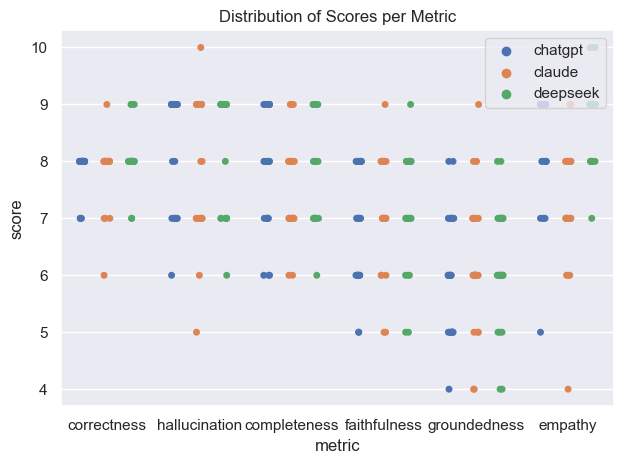

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(data=melted_df, x='metric', y='score', hue='model', jitter=True, dodge=True)
plt.title("Distribution of Scores per Metric")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


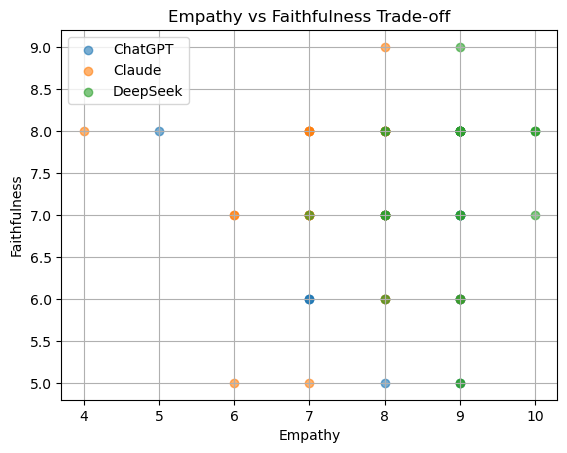

In [21]:
# to discuss whether emotional tone affects factual grounding.
plt.scatter(final_df['chatgpt_empathy'], final_df['chatgpt_faithfulness'], label='ChatGPT', alpha=0.6)
plt.scatter(final_df['claude_empathy'], final_df['claude_faithfulness'], label='Claude', alpha=0.6)
plt.scatter(final_df['deepseek_empathy'], final_df['deepseek_faithfulness'], label='DeepSeek', alpha=0.6)
plt.xlabel("Empathy")
plt.ylabel("Faithfulness")
plt.title("Empathy vs Faithfulness Trade-off")
plt.legend()
plt.grid(True)
plt.show()



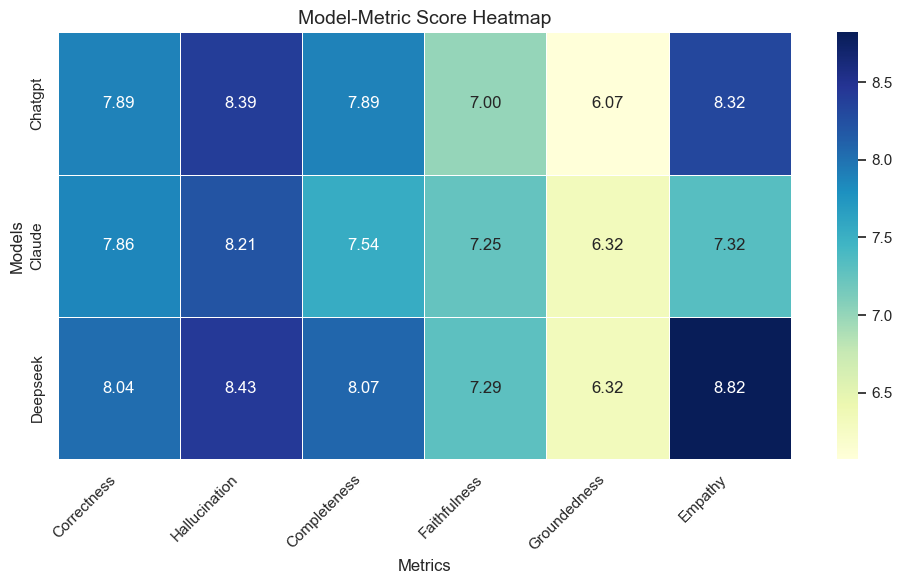

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

#score-only DataFrame (models as rows, metrics as columns)
heatmap_df = pd.DataFrame({
    model.capitalize(): [final_df[f"{model}_{metric}"].mean() for metric in metrics]
    for model in models
}, index=[metric.capitalize() for metric in metrics]).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white'
)
plt.title("Model-Metric Score Heatmap", fontsize=14)
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [31]:
# Step 1: Compute metric-wise average for each model
avg_scores = {
    'ChatGPT': [
        final_df['chatgpt_correctness'].mean(),
        final_df['chatgpt_hallucination'].mean(),
        final_df['chatgpt_completeness'].mean(),
        final_df['chatgpt_faithfulness'].mean(),
        final_df['chatgpt_groundedness'].mean(),
        final_df['chatgpt_empathy'].mean(),
    ],
    'Claude': [
        final_df['claude_correctness'].mean(),
        final_df['claude_hallucination'].mean(),
        final_df['claude_completeness'].mean(),
        final_df['claude_faithfulness'].mean(),
        final_df['claude_groundedness'].mean(),
        final_df['claude_empathy'].mean(),
    ],
    'DeepSeek': [
        final_df['deepseek_correctness'].mean(),
        final_df['deepseek_hallucination'].mean(),
        final_df['deepseek_completeness'].mean(),
        final_df['deepseek_faithfulness'].mean(),
        final_df['deepseek_groundedness'].mean(),
        final_df['deepseek_empathy'].mean(),
    ]
}

metrics = ['correctness', 'hallucination', 'completeness', 'faithfulness', 'groundedness', 'empathy']

# Step 2: Create DataFrame
avg_df = pd.DataFrame(avg_scores, index=metrics).T  # rows = models, columns = metrics

# Step 3: Compute ranks
ranks = avg_df.rank(ascending=False, method='min').astype(int)

# Step 4: Format as "<score> (R<rank>)"
final_ranking_df = avg_df.copy()
for metric in avg_df.columns:
    final_ranking_df[metric] = avg_df[metric].round(2).astype(str) + " (R" + ranks[metric].astype(str) + ")"

# Step 5: Print
print("\n\033[1mMetric-wise Average Scores with Rankings:\033[0m\n")
print(final_ranking_df.to_string())



Metric-wise Average Scores with Rankings:

         correctness hallucination completeness faithfulness groundedness    empathy
ChatGPT    7.89 (R2)     8.39 (R2)    7.89 (R2)     7.0 (R3)    6.07 (R3)  8.32 (R2)
Claude     7.86 (R3)     8.21 (R3)    7.54 (R3)    7.25 (R2)    6.32 (R1)  7.32 (R3)
DeepSeek   8.04 (R1)     8.43 (R1)    8.07 (R1)    7.29 (R1)    6.32 (R1)  8.82 (R1)
